CS 4277: Deep Learning Group Project

## CS 4277: *Deep Learning* Group Project
### Members:
- Nicholas Hodge
- Joshua Peeples
- Jonathan Turner

### This project is our attempt at the Stanford RNA 3D Folding Challenge, found at:

https://www.kaggle.com/competitions/stanford-rna-3d-folding

**For this project to run:**

1. Install matplotlib in your Jupyter Kernel: Block [1]
2. Setup correct path files to your train dataset: Block [7] (there is a comment)

**Future work:**

1. Setup validation correctly
2. Test
3. Return Submission.csv as per requirements

In [20]:
# Uncomment and run if matplotlib not installed
# !  python -m pip install matplotlib

# Replace the following with the location of the dataset root
# Ex: DATASET_ROOT = '/path/to/dataset/files'

#DATASET_ROOT = './data' # Default location for Project
DATASET_ROOT = '../.kaggle/files' # Default location for Project

In [5]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.auto import tqdm

from matplotlib.cm import tab10
import re

# containers to accumulate metrics
batch_loss_history = [] # one entry per batch
epoch_loss_history = [] # one entry per epoch

/home/turner/cs-projects/DL-GroupProject-RNA_Folding/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print (device)

cuda


# Training

In [23]:
NUC_TO_IDX = {
    "A": 0,
    "U": 1,
    "C": 2,
    "G": 3,
    "N": 4 # There are characters *other* than the above 4 sometimes. 'N' is standard for "unknown" (apparently)
}
PAD_IDX = 5
VOCAB_SIZE = len(NUC_TO_IDX) + 1

# Annotated to avoid later confusion - Nick
# This is inherits the Dataset class from pytorch to allow for the dataset to be an Iterable (i.e. work a LOT faster)
class RNADataset(Dataset):
    def __init__(self, seq_csv_path, coords_csv_path):
        # Read both train CSVs (the 'labels' csv -> 'coords')
        self.sequences_df = pd.read_csv(seq_csv_path)
        coords_df_raw = pd.read_csv(coords_csv_path)

        # We are going to get the base_id from each row in coords to associate them with the correct sequence.
        # 1SCL_A_5 becomes 1SCL_A
        coords_df_raw["base_id"] = coords_df_raw["ID"].apply(lambda x: "_".join(x.split("_")[:2]))

        # Now we are going to create groups of coords, where each group corresponds with the same sequence
        # Unfortunately some sequences have missing coord values, but I am going to assume that there are potential
        # sequences that have some missing and some not. So:

        # Method to remove entire groups where *any* row has missing coords
        def is_group_valid(group):
            return group[["x_1", "y_1", "z_1"]].notna().all().all() # returns only rows where all columns are good

        valid_groups = [
            group for _, group in coords_df_raw.groupby("base_id") if is_group_valid(group)
        ]

        # Concatenate all valid groups into a new coords_df
        self.coords_df = pd.concat(valid_groups, ignore_index=True)

        # Build groups and valid sequence IDs list
        self.coord_groups = self.coords_df.groupby("base_id")
        self.valid_ids = set(self.coord_groups.groups.keys())

        # Filter sequences to only include those with clean coordinate groups (prevents later tensors from being mishaped)
        self.sequences_df = self.sequences_df[self.sequences_df["target_id"].isin(self.valid_ids)]

    # Optional but Pytorch docs suggest this for 'Sampler' implmentations (might need that?)
    def __len__(self):
        return len(self.sequences_df)

    # Optional but Pytorch docs suggest this for speedup batched samples loading
    def __getitem__(self, idx):
        row = self.sequences_df.iloc[idx]
        seq_id = row["target_id"]
        sequence = row["sequence"]

        token_ids = [NUC_TO_IDX.get(nuc, NUC_TO_IDX["N"]) for nuc in sequence]
        token_ids = torch.tensor(token_ids, dtype=torch.long)

        # Here we introduce standardization to the coordinates

        # TODO: calculate the following values somewhere in the document in case the dataset changes:
        # Currently precalculated values
        mean_x = 80.44731529117061
        std_x = 147.42231938515297
        mean_y = 84.04072703411182
        std_y = 114.92890150429712
        mean_z = 98.61122565112208
        std_z = 119.41066506340083

        coords_standardized = self.coord_groups.get_group(seq_id)[["x_1", "y_1", "z_1"]].values
        coords_standardized[:, 0] = (coords_standardized[:, 0] - mean_x) / std_x
        coords_standardized[:, 1] = (coords_standardized[:, 1] - mean_y) / std_y
        coords_standardized[:, 2] = (coords_standardized[:, 2] - mean_z) / std_z

        coords = torch.tensor(coords_standardized, dtype=torch.float32)

        return token_ids, coords

In [24]:
# Pad sequences in train_collate_fn
def collate_fn(batch):
    sequences, coords = zip(*batch)

    # Pad sequences with PAD_IDX
    seq_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=PAD_IDX)
    coord_padded = torch.nn.utils.rnn.pad_sequence(coords, batch_first=True, padding_value=0.0)

    # Mask should check against PAD_IDX
    mask = (seq_padded != PAD_IDX).unsqueeze(1).unsqueeze(2)

    return seq_padded, coord_padded, mask

In [25]:
# Source: Aladdin Persson on YouTube (then modified to have an encoder-only architecture)

class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads, dropout):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (self.head_dim * heads == embed_size), "Embed size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, values, keys, query, mask):
        N, value_len, _ = values.shape
        _, key_len, _ = keys.shape
        _, query_len, _ = query.shape

        # Split embedding into self.heads pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        # queries shape: (N, query_len, heads, heads_dim)
        # keys shape: (N, key_len, heads, heads_dim)
        # energy shape: (N, heads, query_len, key_len)

        if mask is not None:
            # mask: (batch, 1, 1, seq_len) -> broadcastable to (batch, heads, query_len, key_len)
            energy = energy.masked_fill(mask == 0, float("-1e9"))

        attention = torch.softmax(energy / (self.embed_size ** 0.5), dim=3)
        attention = self.dropout(attention)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )
        # attention shape: (N, heads, query_len, key_len)
        # values shape: (N, value_len, heads, heads_dim)
        # after einsum (N, query_len, heads, head_dim) then flatten last two dimensions

        out = self.fc_out(out)
        return out

class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads, dropout)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(forward_expansion * embed_size, embed_size)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attention = self.attention(x, x, x, mask)

        x = self.dropout(self.norm1(attention + x))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

class RNA3DFoldPredictor(nn.Module):
    def __init__(self,
                 vocab_size,
                 embed_size,
                 num_layers,
                 heads,
                 forward_expansion,
                 dropout,
                 max_length):
        super().__init__()
        self.embed_size = embed_size
        self.token_embedding = nn.Embedding(vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList([
            TransformerBlock(embed_size, heads, dropout, forward_expansion)
            for _ in range(num_layers)
        ])
        self.fc_out = nn.Linear(embed_size, 3)  # Predict (x, y, z)

    def forward(self, x, mask=None):
        N, seq_len = x.shape

        positions = torch.arange(0, seq_len).unsqueeze(0).expand(N, seq_len).to(x.device)

        out = self.token_embedding(x) + self.position_embedding(positions)
        for layer in self.layers:
            out = layer(out, mask)

        coords = self.fc_out(out)
        return coords

    def predict_multiple(self, x, n_samples=5):
        self.train()  # Activate dropout during inference
        with torch.no_grad():
            outputs = [self(x) for _ in range(n_samples)]
        return torch.stack(outputs)  # Shape: (n_samples, batch_size, seq_len, 3)

In [26]:
# live‑plotter
plot_display_handle = None   # will hold the DisplayHandle returned by display()

def plot_training_progress(epoch):
    # Draw the loss curves without clearing cell output
    global plot_display_handle

    # build figure
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    axs[0].plot(batch_loss_history, linewidth=1)
    axs[0].set_title("Batch loss")
    axs[0].set_xlabel("Batch #")
    axs[0].set_ylabel("Mean Squared Error")

    axs[1].plot(epoch_loss_history, marker="o")
    axs[1].set_title("Epoch loss")
    axs[1].set_xlabel("Epoch")

    plt.tight_layout()
    plt.suptitle(f"Training progress after epoch {epoch+1}", y=1.05, fontsize=14)

    # first call then create display, later calls then update it
    if plot_display_handle is None:
        plot_display_handle = display(fig, display_id=True)
    else:
        plot_display_handle.update(fig)

    plt.close(fig)  # prevent duplicate static image output

In [28]:
dataset = RNADataset(DATASET_ROOT+"/train_sequences.csv", DATASET_ROOT+"/train_labels.csv") # replace with your *actual* path
loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
# Ran at batch_size=2 due to memory constraints FYI

model = RNA3DFoldPredictor(
    vocab_size=VOCAB_SIZE,
    embed_size=64,
    num_layers=4,
    heads=4,
    forward_expansion=4,
    dropout=0.2,
    max_length=4298, # nearest multiple of 2 is 8192...actual max is 4298
).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

test_batch = next(iter(loader))
seqs, coords, mask = [x.to(device) for x in test_batch]

print("Max token ID:", torch.max(seqs))  # Should be <= 3
print("Embedding size:", model.token_embedding.num_embeddings)  # Should be 4

with torch.no_grad():
    outputs = model(seqs, mask)
print("Output shape:", outputs.shape)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    batch_num = 0
    valid_batches = 0 # number of batches that actually updated the model
    last_batch_loss = None # loss of the most recent successful batch
    window_losses = [] # collects losses to compute 50 batch running mean

    # tqdm bar stays in the terminal after finishing (leave=True)
    batch_iterator = tqdm(
        loader,
        desc=f"Epoch {epoch+1}/{num_epochs}",
        unit="batch",
        leave=True,
        position=0,
    )

    for batch_num, (seqs, coords, mask) in enumerate(batch_iterator, start=1):
        # print("Max token ID in batch:", torch.max(seqs))
        seqs, coords, mask = seqs.to(device), coords.to(device), mask.to(device)

        # check for any NaN values
        if torch.isnan(coords).any() or torch.isinf(coords).any():
            batch_iterator.write(f"WARNING: NaN/Inf found in target coordinates in batch {batch_num}! Skipping batch.")
            continue

        optimizer.zero_grad()
        outputs = model(seqs, mask)

        # mask padding tokens only
        non_pad_mask = (seqs != PAD_IDX) # Shape: (batch_size, seq_len)
        outputs_masked = outputs[non_pad_mask]
        coords_masked = coords[non_pad_mask]

        # Calculate loss ONLY on non-padded elements
        if outputs_masked.nelement() == 0:
            batch_iterator.write(f"WARNING: Only padding elements in batch {batch_num}! Skipping batch.")
            continue

        loss = criterion(outputs_masked, coords_masked)

        # Skip if loss is NaN or Inf
        if torch.isnan(loss) or torch.isinf(loss):
            batch_iterator.write(f"WARNING: NaN detected in loss for batch {batch_num}! Skipping batch.")
            # Add more debugging here if needed: print outputs_masked, coords_masked
            continue # Skip optimization step for this batch

        # Backpropagation
        loss.backward()
        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        last_batch_loss = loss.item()
        batch_loss_history.append(last_batch_loss)
        window_losses.append(last_batch_loss)

        total_loss += last_batch_loss
        valid_batches += 1

        # update tqdm bar postfix
        batch_iterator.set_postfix({"batch_loss": f"{last_batch_loss:.4f}"})

        # Every 50 valid batches, print the running mean and reset the window (disabled because it's spammy)
        if len(window_losses) == 50:
            mean50 = sum(window_losses) / 50
            # print(f"Mean loss over batches {batch_num-49}-{batch_num}: {mean50:.4f}")
            window_losses.clear()

    # Epoch‑level summary
    if valid_batches > 0:
        epoch_loss = total_loss / valid_batches
        epoch_loss_history.append(epoch_loss)
        print(
            f"Epoch {epoch+1}/{num_epochs}"
            f" | mean_loss: {epoch_loss:.4f}"
            f" | last_batch_loss: {last_batch_loss:.4f}"
        )
    else:
        print(f"Epoch {epoch+1} had no valid batches or zero total loss.")

    # live plot (comment out for end‑of‑training plot only)
    plot_training_progress(epoch)

Max token ID: tensor(5, device='cuda:0')
Embedding size: 6
Output shape: torch.Size([2, 76, 3])


Epoch 1/10:  46%|████▌     | 138/303 [00:02<00:02, 55.52batch/s, batch_loss=0.7469]


KeyboardInterrupt: 

In [ ]:
model_path = './model.pth'
torch.save(model.state_dict(), model_path)

# Testing

In [ ]:
IDX_TO_NUC = {v: k for k, v in NUC_TO_IDX.items()}
# Testing dataset
class RNATestDataset(Dataset):
    def __init__(self, test_seq_path):
        # Read test csv
        self.data = pd.read_csv(test_seq_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        seq_id = row["target_id"]
        sequence = row["sequence"]

        token_ids = [NUC_TO_IDX.get(nuc, NUC_TO_IDX["N"]) for nuc in sequence]
        token_ids = torch.tensor(token_ids, dtype=torch.long)

        return seq_id, token_ids

In [ ]:
test_dataset = RNATestDataset(test_seq_path=DATASET_ROOT+'/test_sequences.csv')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.load_state_dict(torch.load('model.pth')) # load trained model

model.to(device)
model.eval()

# enable dropout
for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

submission_rows = []

with torch.no_grad():
    for seq_id, token_ids in test_loader:
        seq_id = seq_id[0]  # unpack from list
        token_ids = token_ids.to(device).squeeze(0)  # [seq_len]
        sequence = [IDX_TO_NUC[i.item()] for i in token_ids]

        predictions = []

        # Generate 5 predictions
        for _ in range(5):
            output = model(token_ids.unsqueeze(0))  # [1, seq_len, 3]
            coords = output.squeeze(0).cpu().numpy()  # [seq_len, 3]
            predictions.append(coords)

        predictions = np.stack(predictions, axis=0)  # [5, seq_len, 3]

        seq_len = len(sequence)

        # Loop over each nucleotide in the sequence
        for i in range(seq_len):
            row = {
                "ID": f"{seq_id}_{i+1}",
                "resname": sequence[i],
                "resid": i+1
            }
            for j in range(5):  # 5 predictions
                row[f"x_{j+1}"] = predictions[j, i, 0]
                row[f"y_{j+1}"] = predictions[j, i, 1]
                row[f"z_{j+1}"] = predictions[j, i, 2]

            submission_rows.append(row)

# Convert to DataFrame and save
submission_df = pd.DataFrame(submission_rows)
submission_df.to_csv("submission.csv", index=False)

Prefix: R1107
Prediction 1 points: [(-0.34262028, -0.53546476, -1.0522758), (-0.61037105, -0.407876, -0.6600049), (-0.5466718, -0.53479224, -1.1364745), (-0.70769334, 0.009254158, -0.36622488), (-0.109386966, -0.57015854, -0.72950363), (-0.34441665, -0.2512973, -0.46566617), (-0.4748155, -0.5193826, -0.8738891), (-0.46661937, -0.6316045, -0.7226241), (-0.7206086, -0.05083727, -0.46261144), (-0.33635372, -0.81125504, -1.0301033), (-0.47260392, -0.28587118, -0.6251272), (-0.480767, -0.28234705, -0.4976939), (-0.16537178, -0.19747573, -0.23420802), (-0.7374369, -0.4221648, -0.5483433), (-0.17809704, -0.42892063, -0.41144192), (-0.659463, -0.15162885, -0.75261194), (-0.2608977, -0.62165195, -0.7857283), (-0.6054902, -0.40130585, -0.3267883), (0.00493861, -0.4810381, -0.32405114), (-0.27579978, -0.6541186, -0.47778356), (-0.38715136, -0.43407518, -0.6113315), (-0.41793123, -0.24709633, -0.3109933), (-0.6753364, -0.67045695, -0.62580127), (-0.062097877, -0.8688817, -1.0620977), (-0.28602967,

/tmp/ipykernel_12614/4275556142.py:90: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


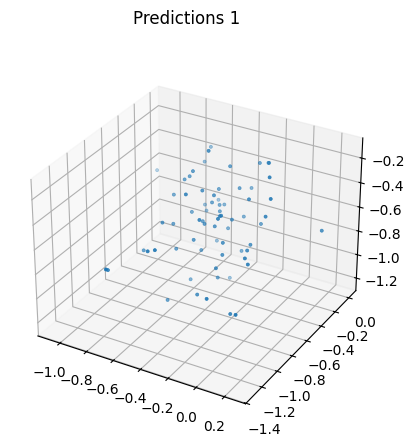

In [11]:
import pandas as pd
import re
from typing import Dict, List

def collect_xyz(df: pd.DataFrame, name_col: str):
    def get_prefix(val: str) -> str:
        return val.rsplit('_', 1)[0]

    # find & sort the x, y, z columns
    x_cols = sorted([c for c in df.columns if re.match(r'x\_\d+', c)], key=lambda c: int(c[2:]))
    y_cols = sorted([c for c in df.columns if re.match(r'y\_\d+', c)], key=lambda c: int(c[2:]))
    z_cols = sorted([c for c in df.columns if re.match(r'z\_\d+', c)], key=lambda c: int(c[2:]))

    results: Dict[str, Dict[str, Dict[List[float]]]] = {}
    current_prefix = None
    xs: Dict[List[float]] = []
    ys: Dict[List[float]] = []
    zs: Dict[List[float]] = []

    for _, row in df.iterrows():
        prefix = get_prefix(str(row[name_col]))
        
        # first row or new group check
        if current_prefix is None:
            current_prefix = prefix
                    
        if prefix != current_prefix:
            # save previous block
            results[current_prefix] = {'x': xs, 'y': ys, 'z': zs}
            # reset for new prefix
            xs, ys, zs = {}, {}, {}
                        
            current_prefix = prefix
            

        # this gives you a list of 5 lists: 0th, 1st, … (N‑1)th every‑Nth element
        xss = [ [ row[c] for c in x_cols[i::5] ] for i in range(5) ]
        yss = [ [ row[c] for c in y_cols[i::5] ] for i in range(5) ]
        zss = [ [ row[c] for c in z_cols[i::5] ] for i in range(5) ]

        # unpack if you really want them as separate variables
        x1s, x2s, x3s, x4s, x5s = xss
        y1s, y2s, y3s, y4s, y5s = yss
        z1s, z2s, z3s, z4s, z5s = zss
        
        # Checks ifi the x,y,z lists are empty
        if not xs:
            xs = {'x1': x1s, 'x2': x2s, 'x3': x3s, 'x4': x4s, 'x5': x5s}
            ys = {'y1': y1s, 'y2': y2s, 'y3': y3s, 'y4': y4s, 'y5': y5s}
            zs = {'z1': z1s, 'z2': z2s, 'z3': z3s, 'z4': z4s, 'z5': z5s}
        else:
            # Append to the existing lists
            xs['x1'].extend(x1s)
            ys['y1'].extend(y1s)
            zs['z1'].extend(z1s)
            xs['x2'].extend(x2s)
            ys['y2'].extend(y2s)
            zs['z2'].extend(z2s)
            xs['x3'].extend(x3s)
            ys['y3'].extend(y3s)
            zs['z3'].extend(z3s)
            xs['x4'].extend(x4s)
            ys['y4'].extend(y4s)
            zs['z4'].extend(z4s)
            xs['x5'].extend(x5s)
            ys['y5'].extend(y5s)
            zs['z5'].extend(z5s)


    # don’t forget the last block
    if current_prefix not in results:
        results[current_prefix] = {'x': xs, 'y': ys, 'z': zs}


    return results

def convert_xyz_to_points(x: List[float], y: List[float], z: List[float]):
    points = [(x[i], y[i], z[i]) for i in range(len(x))]
    return points
    

def generate_plot(predictions_1_points, predictions_2_points, predictions_3_points, predictions_4_points, predictions_5_points):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    
    (x, y, z) = zip(*predictions_1_points)
    
    ax.scatter(x,y,z, marker=".", linewidths=0.5, color=tab10(0), label="Prediction 1")
    fig.suptitle('Predictions 1')
    fig.show()
    
    

df = pd.read_csv("submission.csv")
groups = collect_xyz(df, name_col="ID")
for i, (prefix, coords) in enumerate(groups.items()):
    if i > 0:
        break
    
    x1 = coords['x']['x1']
    x2 = coords['x']['x2']
    x3 = coords['x']['x3']
    x4 = coords['x']['x4']
    x5 = coords['x']['x5']
    y1 = coords['y']['y1']
    y2 = coords['y']['y2']
    y3 = coords['y']['y3']
    y4 = coords['y']['y4']
    y5 = coords['y']['y5']
    z1 = coords['z']['z1']
    z2 = coords['z']['z2']
    z3 = coords['z']['z3']
    z4 = coords['z']['z4']
    z5 = coords['z']['z5']
    
    # Convert to points
    predictions_1_points = convert_xyz_to_points(x1, y1, z1)
    predictions_2_points = convert_xyz_to_points(x2, y2, z2)
    predictions_3_points = convert_xyz_to_points(x3, y3, z3)
    predictions_4_points = convert_xyz_to_points(x4, y4, z4)
    predictions_5_points = convert_xyz_to_points(x5, y5, z5)
    
    generate_plot(predictions_1_points, predictions_2_points, predictions_3_points, predictions_4_points, predictions_5_points)
    
    print(f"Prefix: {prefix}")
    print(f"Prediction 1 points: {predictions_1_points}")
    print(f"Prediction 2 points: {predictions_2_points}")
    print(f"Prediction 3 points: {predictions_3_points}")
    print(f"Prediction 4 points: {predictions_4_points}")
    print(f"Prediction 5 points: {predictions_5_points}")
    
    

In [ ]:
display(pd.read_csv('submission.csv'))

plot_sequence_predictions(submission_df, max_pred=5, max_graphs=1)